In [1]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

# Importing the OpenDSM library

Once the OpenDSM has been installed, it can be imported as shown below.

This tutorial requires OpenDSM version > 1.2.x. Verify the version you have installed.

We will load eemeter and drmeter modules separately

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import (
    eemeter as em,
    drmeter as dm,
)

print(f"OpenDSM {odsm.__version__}")

OpenDSM 1.2.6


## Loading data

The essential inputs to OpenDSM library functions are the following:

1. Meter baseline data named `observed`
2. Meter reporting data `observed`
3. Temperature data from a nearby weather station for both named `temperature`
4. All data is expected to have a timezone-aware datetime index or column named `datetime`

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data.

We utilize data classes to store meter data, perform transforms, and validate the data to ensure data compliance. The inputs into these data classes can either be [pandas](https://pandas.pydata.org/) `DataFrame` if initializing the classes directly or `Series` if initializing the classes using `.from_series`.

The test data contained within the OpenDSM library is derived from [NREL ComStock](https://comstock.nrel.gov/) simulations.

If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

### Important notes about data:
- *These models were developed and tested using Fahrenheit temperature. Please convert your temperatures accordingly*
- *It is expected that all data is trimmed to its appropriate time period (baseline and reporting) and does not contain extraneous datetimes*
- *If you run load_test_data it will download the necessary files from the OpenDSM repository. This can be up to 150 MB*

In [3]:
# Load in test data
#     - This data contains 100 different meters

df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [4]:
print(df_baseline)

                                  temperature  ghi  observed
id     datetime                                             
110596 2018-01-01 00:00:00-06:00     3.322222    0    144.40
       2018-01-01 01:00:00-06:00     2.238889    0    195.92
       2018-01-01 02:00:00-06:00     1.038889    0    204.97
       2018-01-01 03:00:00-06:00    -0.100000    0    205.45
       2018-01-01 04:00:00-06:00    -1.300000    0    207.13
...                                       ...  ...       ...
109141 2018-12-31 18:00:00-06:00    37.672222  339    366.19
       2018-12-31 19:00:00-06:00    36.733333  300    391.01
       2018-12-31 20:00:00-06:00    35.283333  128    227.54
       2018-12-31 21:00:00-06:00    35.561111   54     71.69
       2018-12-31 22:00:00-06:00    35.561111    9     37.56

[875900 rows x 3 columns]


In [5]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.HourlyReportingData(df_reporting_n, is_electricity_data=True)

hourly_model = em.HourlyModel().fit(baseline_data, ignore_disqualification=False)
df_results = hourly_model.predict(baseline_data)
print(df_results.head())

{'n_extreme_values': 2, 'median': 7.24, 'upper_quantile': 12.55, 'lower_quantile': 3.54, 'lower_bound': -23.490000000000006, 'upper_bound': 39.580000000000005, 'min_value': 0.49, 'max_value': 40.06}
{'n_extreme_values': 2, 'median': 7.24, 'upper_quantile': 12.55, 'lower_quantile': 3.54, 'lower_bound': -23.490000000000006, 'upper_bound': 39.580000000000005, 'min_value': 0.49, 'max_value': 40.06}


                           temperature  ghi  observed        date  \
2018-01-01 00:00:00-06:00    -5.077778  0.0     30.34  2018-01-01   
2018-01-01 01:00:00-06:00    -5.977778  0.0     37.36  2018-01-01   
2018-01-01 02:00:00-06:00    -7.061111  0.0     39.38  2018-01-01   
2018-01-01 03:00:00-06:00    -7.061111  0.0     39.91  2018-01-01   
2018-01-01 04:00:00-06:00    -7.061111  0.0     39.41  2018-01-01   

                           hour_of_day  interpolated_temperature  \
2018-01-01 00:00:00-06:00            0                     False   
2018-01-01 01:00:00-06:00            1                     False   
2018-01-01 02:00:00-06:00            2                     False   
2018-01-01 03:00:00-06:00            3                     False   
2018-01-01 04:00:00-06:00            4                     False   

                           interpolated_observed  interpolated_ghi  has_pv  \
2018-01-01 00:00:00-06:00                  False             False       1   
2018-01-01 01:00:00-

In [6]:
print(df_baseline_n)

                           temperature  ghi  observed
datetime                                             
2018-01-01 00:00:00-06:00    -5.077778    0     30.34
2018-01-01 01:00:00-06:00    -5.977778    0     37.36
2018-01-01 02:00:00-06:00    -7.061111    0     39.38
2018-01-01 03:00:00-06:00    -7.061111    0     39.91
2018-01-01 04:00:00-06:00    -7.061111    0     39.41
...                                ...  ...       ...
2018-12-31 18:00:00-06:00    35.061111  339     14.20
2018-12-31 19:00:00-06:00    33.977778  300     15.39
2018-12-31 20:00:00-06:00    33.977778  128     15.26
2018-12-31 21:00:00-06:00    33.977778   54     13.97
2018-12-31 22:00:00-06:00    33.922222    9     14.10

[8759 rows x 3 columns]


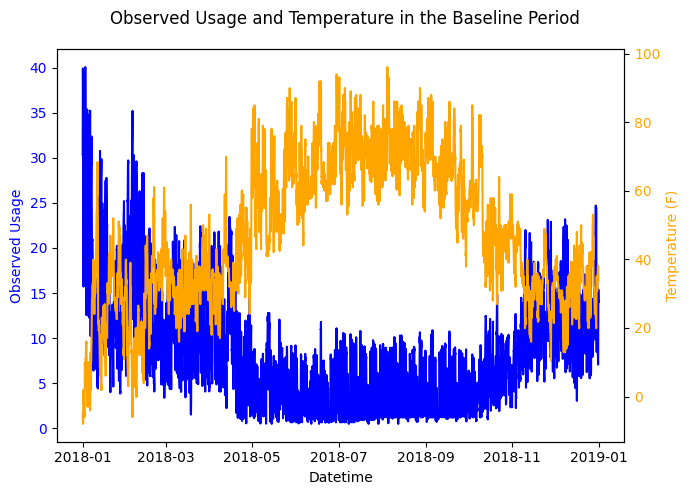

In [7]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(df_baseline_n.index, df_baseline_n['observed'], label='Observed Usage', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(df_baseline_n.index, df_baseline_n['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [8]:
print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]


In [21]:
print(baseline_data.df)

                           temperature    ghi   observed        date  \
2018-01-01 00:00:00-06:00    -5.077778    0.0  30.340000  2018-01-01   
2018-01-01 01:00:00-06:00    -5.977778    0.0  37.360000  2018-01-01   
2018-01-01 02:00:00-06:00    -7.061111    0.0  39.380000  2018-01-01   
2018-01-01 03:00:00-06:00    -7.061111    0.0  39.910000  2018-01-01   
2018-01-01 04:00:00-06:00    -7.061111    0.0  39.410000  2018-01-01   
...                                ...    ...        ...         ...   
2018-12-31 19:00:00-06:00    33.977778  300.0  15.390000  2018-12-31   
2018-12-31 20:00:00-06:00    33.977778  128.0  15.260000  2018-12-31   
2018-12-31 21:00:00-06:00    33.977778   54.0  13.970000  2018-12-31   
2018-12-31 22:00:00-06:00    33.922222    9.0  14.100000  2018-12-31   
2018-12-31 23:00:00-06:00    33.959259    3.0  14.443333  2018-12-31   

                           hour_of_day  interpolated_temperature  \
2018-01-01 00:00:00-06:00            0                     False   

In [22]:
print(df_results.head())

                           temperature  ghi  observed        date  \
2019-01-01 00:00:00-06:00    -5.077778  0.0     23.18  2019-01-01   
2019-01-01 01:00:00-06:00    -5.977778  0.0     29.07  2019-01-01   
2019-01-01 02:00:00-06:00    -7.061111  0.0     30.88  2019-01-01   
2019-01-01 03:00:00-06:00    -7.061111  0.0     31.30  2019-01-01   
2019-01-01 04:00:00-06:00    -7.061111  0.0     30.78  2019-01-01   

                           hour_of_day  interpolated_temperature  \
2019-01-01 00:00:00-06:00            0                     False   
2019-01-01 01:00:00-06:00            1                     False   
2019-01-01 02:00:00-06:00            2                     False   
2019-01-01 03:00:00-06:00            3                     False   
2019-01-01 04:00:00-06:00            4                     False   

                           interpolated_observed  interpolated_ghi  has_pv  \
2019-01-01 00:00:00-06:00                  False             False       1   
2019-01-01 01:00:00-

In [11]:
print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]


In [12]:
df_results

,temperature,ghi,observed,date,hour_of_day,interpolated_temperature,interpolated_observed,interpolated_ghi,has_pv,predicted,predicted_unc
2018-01-01 00:00:00-06:00,-5.077778,0.0,30.340000,2018-01-01,0,False,False,False,1,28.704485,1.478074
2018-01-01 01:00:00-06:00,-5.977778,0.0,37.360000,2018-01-01,1,False,False,False,1,31.935747,1.478074
2018-01-01 02:00:00-06:00,-7.061111,0.0,39.380000,2018-01-01,2,False,False,False,1,33.172401,1.478074
2018-01-01 03:00:00-06:00,-7.061111,0.0,39.910000,2018-01-01,3,False,False,False,1,33.987254,1.478074
2018-01-01 04:00:00-06:00,-7.061111,0.0,39.410000,2018-01-01,4,False,False,False,1,33.976001,1.478074
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00-06:00,33.977778,300.0,15.390000,2018-12-31,19,False,False,False,1,13.117036,1.478074
2018-12-31 20:00:00-06:00,33.977778,128.0,15.260000,2018-12-31,20,False,False,False,1,13.556604,1.478074
2018-12-31 21:00:00-06:00,33.977778,54.0,13.970000,2018-12-31,21,False,False,False,1,13.792530,1.478074
2018-12-31 22:00:00-06:00,33.922222,9.0,14.100000,2018-12-31,22,False,False,False,1,14.108415,1.478074


In [23]:
df_results = hourly_model.predict(reporting_data)

df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Predicted Usage (kWh):  76476.57
Observed Usage (kWh):   58789.85
Savings (kWh):          17686.72


In [14]:
saved_model = hourly_model.to_json()
print(saved_model)

{"settings": {"train_features": ["temperature", "ghi"], "cvrmse_threshold": 1.4, "pnrmse_threshold": 2.2, "min_daily_training_hours": 12, "temperature_bin": {"method": "fixed_bins", "n_bins": null, "bin_width": 25, "fixed_bins": [10, 30, 50, 65, 75, 90, 105], "min_bin_count": 20, "include_edge_bins": true, "edge_bin_rate": "heuristic", "edge_bin_percent": null, "edge_bin_temperature_range_offset": 1.0}, "temporal_cluster": {"standardize": true, "transform_settings": {"wavelet_n_levels": 4, "wavelet_name": "db1", "wavelet_mode": "smooth", "pca_method": "pca", "pca_min_variance_ratio_explained": null, "pca_n_components": "mle", "pca_include_median": true}, "algorithm_selection": "spectral", "bisecting_kmeans": null, "birch": null, "dbscan": null, "hdbscan": null, "spectral": {"eigen_solver": "arpack", "n_components": null, "affinity": "rbf", "nearest_neighbors": 5, "gamma": 1.05, "eigen_tol": "auto", "assign_labels": "cluster_qr", "n_cluster": {"lower": 2, "upper": 24}, "scoring": {"min_

In [15]:
# set rows 1:38 of observed to nan
df_baseline_n_dq = df_baseline_n.copy()
df_baseline_n_dq.loc[df_baseline_n_dq.index[1:76], "observed"] = np.nan

baseline_data_DQ = em.HourlyBaselineData(df_baseline_n_dq, is_electricity_data=True)
print(f"Disqualifications: {baseline_data_DQ.disqualification}")

{'lowest_monthly_coverage': 0.8991935483870968}


Disqualifications: [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.missing_monthly_observed_data)]


In [16]:
import numpy as np
import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import eemeter as em

df_baseline, df_reporting =  odsm.test_data.load_test_data("hourly_treatment_data")

n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.HourlyReportingData(df_reporting_n, is_electricity_data=True)

print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

hourly_model = em.HourlyModel()
hourly_model.fit(baseline_data)

# Save model to json
saved_model = hourly_model.to_json()
loaded_model = em.HourlyModel.from_json(saved_model)

# Model results
df_results = hourly_model.predict(reporting_data)
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

{'n_extreme_values': 2, 'median': 7.24, 'upper_quantile': 12.55, 'lower_quantile': 3.54, 'lower_bound': -23.490000000000006, 'upper_bound': 39.580000000000005, 'min_value': 0.49, 'max_value': 40.06}
{'n_extreme_values': 2, 'median': 7.24, 'upper_quantile': 12.55, 'lower_quantile': 3.54, 'lower_bound': -23.490000000000006, 'upper_bound': 39.580000000000005, 'min_value': 0.49, 'max_value': 40.06}


Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]
Predicted Usage (kWh):  76476.57
Observed Usage (kWh):   58789.85
Savings (kWh):          17686.72


In [17]:
hourly_model.plot(baseline_data)

NotImplementedError: 

In [ ]:
df_results = hourly_model.predict(baseline_data)

# Decimate data: plot every 24th point (i.e., daily for hourly data)
decimation_factor = 1
df_results_decimated = df_results.iloc[::decimation_factor, :]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: Observed and Predicted Usage
ax1.plot(df_results_decimated.index, df_results_decimated['observed'], label='Observed Usage')
ax1.plot(df_results_decimated.index, df_results_decimated['predicted'], label='Predicted Usage')
ax1.set_ylabel('Usage [kWh]')
ax1.legend()

# Lower panel: Residuals
residuals_decimated = df_results_decimated['observed'] - df_results_decimated['predicted']
ax2.plot(df_results_decimated.index, residuals_decimated, color='purple', label='Residuals (Observed - Predicted)')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Residuals [kWh]')

ax1.set_xlim(df_results_decimated.index.min(), df_results_decimated.index.max())
ax2.set_xlim(df_results_decimated.index.min(), df_results_decimated.index.max())

fig.subplots_adjust(hspace=0)

plt.show()

In [ ]:
hourly_model.plot(reporting_data)

In [ ]:
df_results = hourly_model.predict(reporting_data)
print(df_results.head())

In [ ]:
df_results

In [ ]:
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

In [ ]:
saved_model = hourly_model.to_json()
print(saved_model)

In [ ]:
loaded_model = em.HourlyModel.from_json(saved_model)

In [ ]:
# set rows 1:380 of observed to nan
df_baseline_n_dq = df_baseline_n.copy()
df_baseline_n_dq.loc[df_baseline_n_dq.index[1:76], "observed"] = np.nan

baseline_data_DQ = em.HourlyBaselineData(df_baseline_n_dq, is_electricity_data=True)
print(f"Disqualifications: {baseline_data_DQ.disqualification}")

In [ ]:
try:
    hourly_model = em.HourlyModel().fit(baseline_data_DQ)
except Exception as e:
    print(f"Exception: {e}")

In [ ]:
hourly_model = em.HourlyModel().fit(baseline_data_DQ, ignore_disqualification=True)

## Full Example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import eemeter as em

df_baseline, df_reporting =  odsm.test_data.load_test_data("monthly_treatment_data")

n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

hourly_model = em.BillingModel()
hourly_model.fit(baseline_data)

# Save model to json
saved_model = hourly_model.to_json()
loaded_model = em.BillingModel.from_json(saved_model)

# Model results
hourly_model.plot(baseline_data, aggregation="monthly")
hourly_model.plot(reporting_data, aggregation="monthly")

df_results = hourly_model.predict(reporting_data, aggregation="monthly")
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Similarly, the plot function also has the ability to aggregate to `monthly` or `bimonthly`. 

This model is still at its core, a modified daily model though. This is why the model prediction is not straight for either of the aggregations.

In [ ]:
hourly_model.plot(baseline_data)

hourly_model.plot(baseline_data, aggregation="monthly")

hourly_model.plot(baseline_data, aggregation="bimonthly")

## HOURLY Energy Efficiency Model

Just like the daily and billing model, we follow the same calls but for new data classes and model.

In [ ]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [ ]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = em.HourlyReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

hourly_model = em.HourlyModel().fit(hourly_baseline_data)

In [ ]:
hourly_model.predict(hourly_baseline_data)

## Hourly Demand Response Model

Finally, we have a demand response model meant to be used for measuring short-term demand response events within `drmeter`, but it too follows the same API structure

In [ ]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [ ]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = dm.CaltrackDRBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = dm.CaltrackDRReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

dr_model = dm.CaltrackDRModel().fit(hourly_baseline_data)

In [ ]:
dr_model.predict(hourly_baseline_data)

## How to calculate savings or avoided energy use

Savings calculation functions are not provided in `eemeter`, but to calculate basic savings is a summation of the subtraction of reporting year observed from baseline year prediction for 1 year.

- Savings = sum(predicted_baseline - observed_reporting)

In [ ]:
from PIL import Image

# Load the image
img_path = "/app/applied_data_science/opendsm-website/src/assets/images/eemeter/hourly_model/temperature_bins.png"
img = Image.open(img_path).convert("RGBA")

# Create a white background image
white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))

# Composite the original image onto the white background
composited = Image.alpha_composite(white_bg, img)

# Convert back to RGB (no alpha) and save, overwriting the original
composited.convert("RGB").save(img_path)

print(f"Image at {img_path} has been updated to have a white background.")


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X**0.5)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

title = ["Underfit", "Well Fit", "Overfit"]

plt.figure(figsize=(12, 3), dpi=300)
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    # plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x", fontsize=12)
    if i == 0:
        plt.ylabel("y", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((-2.5, 2.5))
    # plt.legend(loc="best")
    plt.title(title[i], fontsize=14)
    
plt.subplots_adjust(wspace=0.05)
plt.show()